# Imports

In [1]:
import os
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn import datasets #Retirar após o uso do dataset do Hackday
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score

# Global variables

In [2]:
rawData = pd.DataFrame()
outliersData = pd.DataFrame()

# Functions

In [3]:
def loadData(x: str):
    """Função para carregar arquivo csv com a base de dados"""
    global rawData
    if not os.path.exists(x):
        print("Arquivo não encontrado.")
        return None
    rawData = pd.DataFrame(pd.read_csv(x))
    return

def checkData():
    print(f"Info dos valores:\n{rawData.info()}\n")
    print(f"Descrição dos dados:\n{rawData.describe()}\n")
    print(f"Número de nulos por coluna:\n{rawData.isnull().sum()}\n")
    print(f"Tipos das colunas:\n{rawData.dtypes}\n")
    return

def checkCorrelation():
    plt.figure(figsize=(10,8))
    sns.heatmap(rawData.select_dtypes(include=[np.number]).corr(), annot=True)
    plt.show()
    return

def checkOutliers():
    global outliersData
    outliers_df = pd.DataFrame()
    # Itera sobre as colunas númericas
    for column in rawData.select_dtypes(include=[np.number]).columns:
        # Calcula o 1 quartil (Q1)
        Q1 = rawData[column].quantile(0.25)
        # Calcula o 3 quartil (Q3)
        Q3 = rawData[column].quantile(0.75)
        # Calcula o Intervalo Interquartil (IQR)
        IQR = Q3 - Q1
        # Define os limites inferior e superior para outliers
        lower_bound = Q1 - 1.5 * IQR
        upper_bound = Q3 + 1.5 * IQR
        # Identica os outliers da coluna atual e adiciona ao DataFrame de outliers
        outliers = rawData[(rawData[column] < lower_bound) | (rawData[column] > upper_bound)]
        # Concatene os outliers da coluna atual ao DataFrame de outliers
        outliers_df = pd.concat([outliers_df, outliers])
    outliersData = outliers_df.drop_duplicates().reset_index(drop=True)
    print(f"Sample de outliers:\n{outliersData.sample(5)}")
    return


# Loading data

In [4]:
loadData("dataset/concatData.csv")

/tmp/ipykernel_1413/198147520.py:7: DtypeWarning: Columns (8,9,20,30) have mixed types. Specify dtype option on import or set low_memory=False.
  rawData = pd.DataFrame(pd.read_csv(x))


In [5]:
rawData.sample(10)

,book_id,title_x,author_id,first_name,last_name,birthday,country_residence,hrs_writing_day,title_y,award_name,...,country,year_established,marketing_spend,pub_id_y,series_name,sale_date,discount,item_id,order_id,mean_rating
164569,TM925,The Mallemaroking,BT132,Bianca,Thompson,28/1/2150,United States,5.0,The Mallemaroking,Hugo Award,...,USA,1889.0,2320000.0,ESP,The Mallemaroking Saga,8/12/2193,NaN,107360-39-8318,107360-45779,4.659653
372864,TO369,The Scent of Oranges,LD375,Lynne,Danticat,19/8/2155,New Zealand,8.0,NaN,NaN,...,New Zealand,1973.0,151000.0,SSC,Esme s Ladies,7/7/2193,NaN,107206-76-6655,107206-20198,4.166113
314338,TM925,The Mallemaroking,BT132,Bianca,Thompson,28/1/2150,United States,5.0,The Mallemaroking,Nebula Award,...,USA,1889.0,2320000.0,ESP,The Mallemaroking Saga,15/1/2193,NaN,107033-79-1582,107033-960,4.659653
174032,TM925,The Mallemaroking,BT132,Bianca,Thompson,28/1/2150,United States,5.0,The Mallemaroking,Hugo Award,...,USA,1889.0,2320000.0,ESP,The Mallemaroking Saga,27/12/2193,NaN,107379-69-6361,107379-49466,4.659653
119071,TA182,The Spark and The Ashes,UK129,Ursula,Karénine,25/2/2156,United Kingdom,9.0,The Spark and The Ashes,National Book Award,...,USA,1889.0,2320000.0,ESP,NaN,4/7/2193,NaN,107203-9-6854,107203-19475,4.358907
277622,TM925,The Mallemaroking,BT132,Bianca,Thompson,28/1/2150,United States,5.0,The Mallemaroking,Nebula Award,...,USA,1889.0,2320000.0,ESP,The Mallemaroking Saga,13/12/2193,NaN,107365-67-5094,107365-46583,4.659653
185057,TM925,The Mallemaroking,BT132,Bianca,Thompson,28/1/2150,United States,5.0,The Mallemaroking,Hugo Award,...,USA,1889.0,2320000.0,ESP,The Mallemaroking Saga,7/7/2193,NaN,107206-22-1711,107206-20204,4.659653
254376,TM925,The Mallemaroking,BT132,Bianca,Thompson,28/1/2150,United States,5.0,The Mallemaroking,Hugo Award,...,USA,1889.0,2320000.0,ESP,The Mallemaroking Saga,10/6/2193,NaN,107179-74-6871,107179-15523,4.659653
335508,TM925,The Mallemaroking,BT132,Bianca,Thompson,28/1/2150,United States,5.0,The Mallemaroking,Nebula Award,...,USA,1889.0,2320000.0,ESP,The Mallemaroking Saga,26/8/2193,NaN,107256-46-5379,107256-32347,4.659653
322500,TM925,The Mallemaroking,BT132,Bianca,Thompson,28/1/2150,United States,5.0,The Mallemaroking,Nebula Award,...,USA,1889.0,2320000.0,ESP,The Mallemaroking Saga,18/10/2193,NaN,107309-86-2658,107309-39977,4.659653


# Descrição

In [6]:
dfClean = rawData().drop(columns=['author_id'])
dfClean["full_name"] = dfClean.apply(lambda row: row["first_name"] + " " + row["last_name"], axis=1)
dfClean.sample(10)


In [7]:
checkData()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 394499 entries, 0 to 394498
Data columns (total 36 columns):
 #   Column             Non-Null Count   Dtype  
---  ------             --------------   -----  
 0   book_id            394499 non-null  object 
 1   title_x            394499 non-null  object 
 2   author_id          394499 non-null  object 
 3   first_name         394499 non-null  object 
 4   last_name          394499 non-null  object 
 5   birthday           394499 non-null  object 
 6   country_residence  394499 non-null  object 
 7   hrs_writing_day    394499 non-null  float64
 8   title_y            307438 non-null  object 
 9   award_name         307438 non-null  object 
 10  year_won           307438 non-null  float64
 11  isbn               394498 non-null  object 
 12  format_id          394498 non-null  float64
 13  pub_id_x           394498 non-null  object 
 14  publication_date   394498 non-null  object 
 15  pages              394498 non-null  float64
 16  pr

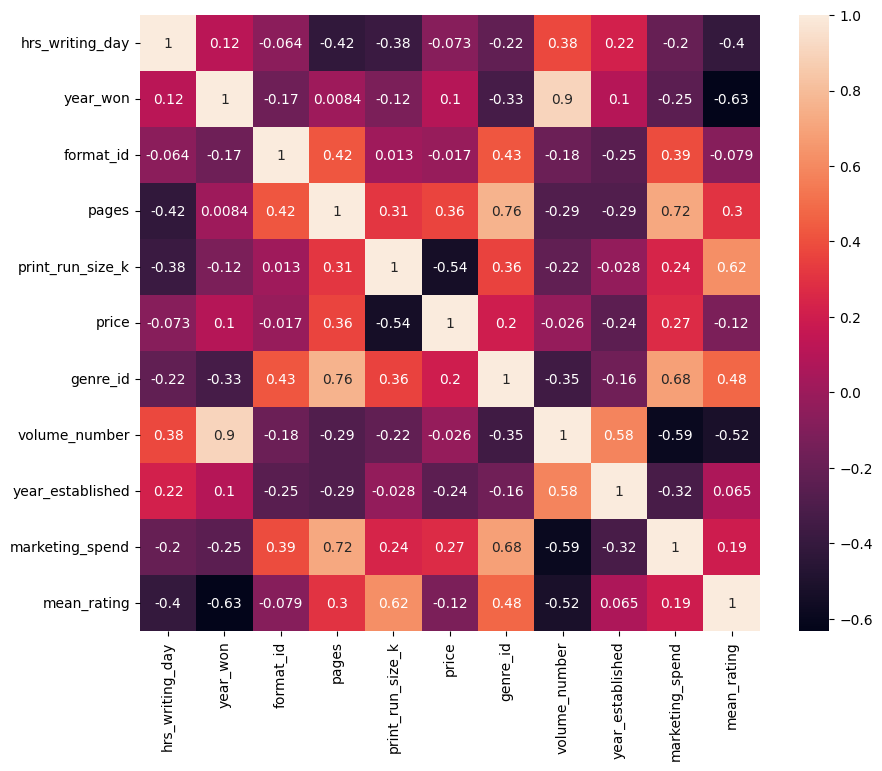

In [8]:
checkCorrelation()

In [9]:
checkOutliers()

Sample de outliers:
      book_id                              title_x author_id first_name  \
38073   CH391                     Can I Be Honest?     CF829    Charles   
6923    LB510                      Lace and Brandy     LD375      Lynne   
16584   WG715                   Whither Thou Goest     LD375      Lynne   
51396   TH296  The Winchcombe Railway Museum Heist     CS190    Carolyn   
21201   IC739   Inconvenient Confessions: a memoir     OL640     Oliver   

      last_name   birthday country_residence  hrs_writing_day  \
38073  Fenimore  18/3/2120            Norway              7.0   
6923   Danticat  19/8/2155       New Zealand              8.0   
16584  Danticat  19/8/2155       New Zealand              8.0   
51396     Segal  24/9/2133     United States              7.0   
21201     Lowry  29/8/2155       Netherlands              4.0   

                                  title_y award_name  ...      country  \
38073                                 NaN        NaN  ...       

# Limpeza

# Feature Enginnering

# Filtragem de variáveis

# Ánalise exploratoria (EDA)

# Preparação dos dados

# Seleção de variáveis

# Treinamento e avaliação de modelos

## Regressão linear

In [10]:
# Verificando o nome das colunas
column_names = rawData.columns.tolist()
print(column_names)

['book_id', 'title_x', 'author_id', 'first_name', 'last_name', 'birthday', 'country_residence', 'hrs_writing_day', 'title_y', 'award_name', 'year_won', 'isbn', 'format_id', 'pub_id_x', 'publication_date', 'pages', 'print_run_size_k', 'price', 'format_desc', 'genre_id', 'series_id', 'volume_number', 'genre_desc', 'name', 'city', 'state', 'country', 'year_established', 'marketing_spend', 'pub_id_y', 'series_name', 'sale_date', 'discount', 'item_id', 'order_id', 'mean_rating']


In [11]:

X = rawData[column_names[0:-2]]
y = rawData[column_names[6:8]]
model = LinearRegression()
model.fit(X, y)
predictions = model.predict(X)
predictions.shape

ValueError: could not convert string to float: 'AD222'

## 2.7 - Fine Tuning

## 2.8 - Deploy

# Conclusões

## 3.2 - Insights